#### Sử dụng LDA phân lớp và so sánh với sử dụng softmax để phân lớp

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import minimize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time
%matplotlib inline

In [2]:
# Tải dữ liệu lên từ file matlab
import scipy.io as sio

data = sio.loadmat("data.mat")

# giá trị điểm ảnh của các chữ số viết tay

# Gồm 5000 ảnh, mỗi ảnh có độ phân giải 20x20
X = data["X"]

# nhãn
y = data["y"]

y = y.reshape(len(y))
for j in range(len(y)):
    if y[j] == 10:
        y[j] = 0
m, n = X.shape

m,n

(5000, 400)

In [3]:
# y(i,j) nhãn của ảnh thứ j lớp thứ i
_y = y.reshape(10,500)
# X(i,j,k) data của ảnh thứ j lớp thứ i
_X = X.reshape(10,500,400)

In [4]:
# mỗi lớp có 500 ảnh, lấy 400 ảnh train, 100 ảnh test
X_train = _X[:,:400,:]
X_test = _X[:,400:,:]
y_train = _y[:,:400]
y_test = _y[:,400:]
X_train = X_train.reshape(4000,400)
X_test = X_test.reshape(1000,400)
y_train = y_train.reshape(4000)
y_test = y_test.reshape(1000)



In [5]:
# Thêm một cột bias cho dũ liệu đầu vào X_train
bias = np.ones((4000,1))
X_train_bias = np.append(bias, X_train, axis=1)
# Thêm một cột bias cho dũ liệu đầu vào X_test
bias = np.ones((1000,1))
X_test_bias = np.append(bias, X_test, axis=1)

Trực quan hóa dữ liệu

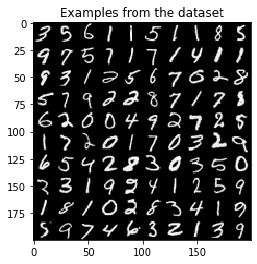

In [6]:
# Hiển thị ngẫu nhiên 100 chữ viết tay trong tập dữ liệu
import random
from PIL import Image

num_samples = 100
samples = random.sample(list(X), num_samples)
display_img = Image.new('RGB', (200, 200))

# Đưa 100 ảnh vào display_img
i = 0
for col in range(10):
    for row in range(10):
        array = samples[i]
        array = ((array / max(array)) * 255).reshape((20, 20)).transpose()
        img = Image.fromarray(array)
        display_img.paste(img, (col*20, row*20))
        i += 1

# Show ảnh
plt.title('Examples from the dataset')
plt.imshow(display_img, interpolation='nearest')

### Sử dụng softmax để phân lớp

In [7]:
# hàm tính softmax
def softmax(Z):
    e_Z = np.exp(Z)
    return e_Z / np.sum(e_Z)

# hàm tính cost
def compute_cost(theta, X, y):
    m = len(y)
    z = X@theta.T
    y_pre = np.zeros(y.shape)
    for i in range(m):
        y_pre[i] = softmax(z[i])
    cost = -np.sum(y*np.log(y_pre))
    return cost 

# hàm tính gradient
def compute_gradient(theta, X, y):
    m = len(y)
    n = len(theta)
    z = X@theta.T
    y_pre = np.zeros(y.shape)
    for i in range(m):
        y_pre[i] = softmax(z[i])
    gradient = X.T @ (y_pre - y)
    return gradient

In [8]:
# chuyển các nhãn thành các vector one-hot
def mapper(y,K):
    Y = np.zeros((len(y),K))
    for i in range(len(y)):
        for j in range(0,K):
            if (y[i]==j):
                Y[i][j] = 1
            else:
                Y[i][j] = 0
    return Y

In [9]:
# Train mô hình softmax
def train(X, y, K,epoch, lr):
    n = X.shape[1]
    tmp = np.zeros(len(y))
    theta = np.zeros((K, n))
    Y = mapper(y,K)
    for i in range(epoch):
        cost = compute_cost(theta,X,Y)
        theta_grad = compute_gradient(theta,X,Y)
        theta = theta - lr*theta_grad.T
        if ((i+1)%50==0):
            print("loss in epoch " + str(i+1) + " = " + str(cost))
    return theta

In [10]:
# Train với epoch = 950 và learningrate = 0.01
K = 10
start_time = time.time()
theta = train(X_train_bias, y_train, K,950,0.01)
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\PC\AppData\Local\Temp/ipykernel_16188/2170545745.py:13: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(y*np.log(y_pre))
C:\Users\PC\AppData\Local\Temp/ipykernel_16188/2170545745.py:13: RuntimeWarning: invalid value encountered in multiply
  cost = -np.sum(y*np.log(y_pre))


loss in epoch 50 = 16427.80749765432
loss in epoch 100 = 4028.802031710714
loss in epoch 150 = 7338.889454022058
loss in epoch 200 = 3180.829008443657
loss in epoch 250 = 2006.8159389732052
loss in epoch 300 = 3177.580131412338
loss in epoch 350 = 16820.569508463614
loss in epoch 400 = 1636.8071040939421
loss in epoch 450 = 1824.0600391708108
loss in epoch 500 = 1263.1461314460162
loss in epoch 550 = 1160.1496725661702
loss in epoch 600 = 1137.0418172211455
loss in epoch 650 = 1393.835758301134
loss in epoch 700 = 1604.9621683887224
loss in epoch 750 = 626.9833418355233
loss in epoch 800 = 1147.5927295361034
loss in epoch 850 = 827.5313331228652
loss in epoch 900 = 1396.807887670932
loss in epoch 950 = 534.1831686865638
--- 238.79628252983093 seconds ---


In [11]:
z = X_test_bias@theta.T
y_pre = np.zeros((len(y_test),10))
for i in range(1000):
    y_pre[i] = softmax(z[i])
accuracy = np.mean(np.argmax(y_pre, axis = 1) == y_test) * 100
'Training set accuracy using multi-class classification: {:2}%'.format(accuracy)

'Training set accuracy using multi-class classification: 87.6%'

### Sử dụng LDA của sklearn

#### Giảm chiều dữ liệu còn 10

In [12]:
#Giảm số chiều từ 400 xuống min(n_classes - 1, n_features) = 10
start_time = time.time()
lda_10 = LDA()
lda_10.fit(X,y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.2075605392456055 seconds ---


In [13]:
# dự đoán nhãn cho tập test
y_pre = lda_10.predict(X_test)

In [14]:
# kiểm tra độ chính xác của mô hình
accuracy = np.mean(y_pre == y_test) * 100
'Training set accuracy use LDA for classification: {:2}%'.format(accuracy)

'Training set accuracy use LDA for classification: 90.7%'

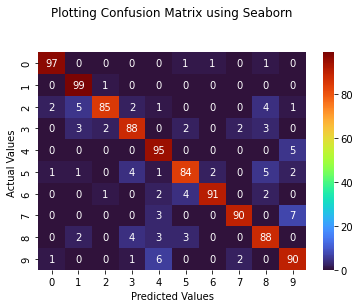

In [15]:
from sklearn import metrics
import seaborn as sebrn
confusion_matrix = metrics.confusion_matrix(y_test, y_pre)
# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(confusion_matrix, annot=True, cmap='turbo')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');

plt.show()